In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import sympy as sym
import numpy as np
import scipy as sp

from sympy import sin, cos

sns.set()
plt.rcParams["figure.figsize"] = (8,8)

# Part A

First find the FIM:
$$F_\theta = \frac{\partial \mu(\theta)}{\partial \theta}^T Q^{-1} \frac{\partial \mu(\theta)}{\partial \theta}$$

<br>

$$\frac{\partial \mu(\theta)}{\partial \theta} = \begin{bmatrix} 
    \frac{\partial}{\partial \theta} \big (1 - cos(\theta) \big ) \\
    \frac{\partial}{\partial \theta} \big (1 - cos(2\theta) \big ) \\
    \frac{\partial}{\partial \theta} \big (1 - cos(3\theta) \big ) \\
    \frac{\partial}{\partial \theta} \big (1 - cos(4\theta) \big ) \\
\end{bmatrix} = \begin{bmatrix} 
    sin(\theta) \\
    2 sin(2\theta) \\
    3 sin(3\theta) \\
    4 sin(4\theta) \\
\end{bmatrix}$$

<br>

\begin{align*}
F_\theta &= \frac{1}{\sigma^2}\big (sin(\theta) \big )^2 + \frac{1}{\sigma^2}\big (2 sin(2\theta) \big )^2 + \frac{1}{\sigma^2}\big (3 sin(3\theta) \big )^2 + \frac{1}{\sigma^2}\big (4 sin(4\theta) \big )^2 \\
         &= \frac{1}{\sigma^2} \Big (sin^2(\theta) + 4 sin^2(2\theta) + 9 sin^2(3\theta) + 16 sin^2(4\theta) \Big ) \\
         &= \frac{1}{\sigma^2} \sum\limits_{i=1}^{4} i^2 sin(i \theta)
\end{align*}


In [4]:
sigma_2 = 1  # Sigma squared
thetas = np.linspace(0, np.pi, 1000)  # Theta range from 0 to pi

def fisher(sigma_2, theta):
    return (1 / sigma_2) * ((np.sin(theta))**2 + (2 * np.sin(2 * theta))**2 + (3 * np.sin(3 * theta))**2 + (4 * np.sin(4 * theta))**2)


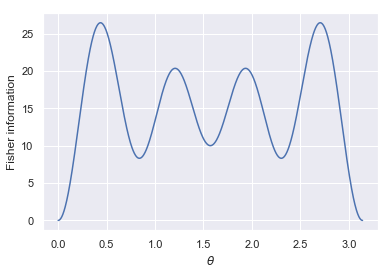

In [5]:
plt.plot(thetas, fisher(sigma_2, thetas))
plt.xlabel("$\\theta$")
plt.ylabel("Fisher information")
plt.show()

# Part B

## Creating a maximum likelihood estimator function
I couldn't find a function like `lsqnonlin()`, so I just created my own MLE finder

Skipping a few steps here, but essentially we know the problem is a Gaussian, find the $\theta$ that makes the data most probable from the pdf. To do that we just find the point where the derivative of the log probability is equal to zero (or if you can't find the solution analytically, where it is very close to zero works too).

On paper for the derivative of the gaussian with respect to $\theta$  I got:

$$\frac{\partial}{\partial \theta} f(x | \theta)= \frac{1}{\sigma^2} \Big [
    (x_1 + cos(\theta) - 1)sin(\theta) +
    2(x_1 + cos(2\theta) - 1)sin(2\theta) +
    3(x_1 + cos(3\theta) - 1)sin(3\theta) +
    4(x_1 + cos(4\theta) - 1)sin(4\theta)
\Big ]$$

In [198]:
theta, sigma_2, x1, x2, x3, x4 = sym.symbols('\\theta \sigma^2 x_1, x_2, x_3, x_4')
eq = (-1 / (2 * sigma_2)) * (
    (x1 - (1 - cos(1*theta)))**2 + 
    (x2 - (1 - cos(2*theta)))**2 + 
    (x3 - (1 - cos(3*theta)))**2 + 
    (x4 - (1 - cos(4*theta)))**2
)
sym.simplify(eq.diff(theta))  # Check if it matches paper derivation

((x_1 + cos(\theta) - 1)*sin(\theta) + 2*(x_2 + cos(2*\theta) - 1)*sin(2*\theta) + 3*(x_3 + cos(3*\theta) - 1)*sin(3*\theta) + 4*(x_4 + cos(4*\theta) - 1)*sin(4*\theta))/\sigma^2

In [201]:
# Also calculate the hessian to be able to use newtons method
print(sym.simplify(sym.hessian(eq, [theta])[0]))

((x_1 + cos(\theta) - 1)*cos(\theta) + 4*(x_2 + cos(2*\theta) - 1)*cos(2*\theta) + 9*(x_3 + cos(3*\theta) - 1)*cos(3*\theta) + 16*(x_4 + cos(4*\theta) - 1)*cos(4*\theta) - sin(\theta)**2 - 4*sin(2*\theta)**2 - 9*sin(3*\theta)**2 - 16*sin(4*\theta)**2)/\sigma^2


In [ ]:
def cost_fn(x, theta, sigma_2):
    return (x[0] - np.cos(theta))**2 + (x[1] - np.cos(2*theta))**2 + (x[2] - np.cos(3*theta))**2 + (x[3] - np.cos(4*theta))**2

def grad_theta_fn(x, theta, sigma_2):
    return np.array(((x[0] + np.cos(theta) - 1)*np.sin(theta) + 2*(x[1] + np.cos(2*theta) - 1)*np.sin(2*theta) + 3*(x[2] + np.cos(3*theta) - 1)*np.sin(3*theta) + 4*(x[3] + np.cos(4*theta) - 1)*np.sin(4*theta)) / sigma_2)

def inv_hess_theta_fn(x, theta, sigma_2):
    return np.array(sigma_2 / ((x[0] + np.cos(theta) - 1)*np.cos(theta) + 4*(x[1] + np.cos(2*theta) - 1)*np.cos(2*theta) + 9*(x[2] + np.cos(3*theta) - 1)*np.cos(3*theta) + 16*(x[3] + np.cos(4*theta) - 1)*np.cos(4*theta) - np.sin(theta)**2 - 4*np.sin(2*theta)**2 - 9*np.sin(3*theta)**2 - 16*np.sin(4*theta)**2))
    
    
def mle(x, theta0=0.5, sigma_2=0.1, cost_fn, grad_theta_fn=None, inv_hess_theta_fn=None, ftol=None, gtol=None):
    """
    x               : Data point
    theta0            : Initial parameter estimate
    sigma_2           : Sigma^2 of the Gaussian function
    cost_fn           : Cost function that you want to minimize
    grad_theta_fn     : Gradient of the cost function w.r.t. the parameter being optimized
    inv_hess_theta_fn : Inverse of the hessian of the cost function w.r.t. the parameter being optimized
    ftol              : Stopping criteria using the cost function (always non-negative)
    gtol              : Stopping criteria using the norm of the gradient
    
    """
    theta = theta0
    
    # Get initial cost, grad, and hess
    cost = cost_fn(x, theta, sigma_2)
    grad_theta = np.asarray(grad_theta_fn(x, theta, sigma_2))
    inv_hess_theta = np.asarray(inv_hess_theta_fn(x, theta, sigma_2))

    if ftol is not None:
        while cost > ftol:
            theta -= inv_hess_theta @ grad_theta

            cost = cost_fn(x, theta, sigma_2)
            grad_theta = np.asarray(grad_theta_fn(x, theta, sigma_2))
            inv_hess_theta = np.asarray(inv_hess_theta_fn(x, theta, sigma_2))
        
    elif gtol is not None:
        while np.abs(grad_theta) > gtol:
            pass
        
    else:
        raise ValueError('One of ftol or gtol must be specified.')
    

In [204]:
[1] @ [2.3]

TypeError: unsupported operand type(s) for @: 'list' and 'list'

In [74]:
def sample_x(theta, n=1000, sigma_2=0.1):
    """Same as np.random.multivariate_normal but 2x faster for diagonal covariances"""
    return np.array([
        np.random.normal(1 - np.cos(theta), sigma_2, size=n),
        np.random.normal(1 - np.cos(2*theta), sigma_2, size=n),
        np.random.normal(1 - np.cos(3*theta), sigma_2, size=n),
        np.random.normal(1 - np.cos(4*theta), sigma_2, size=n),
    ])

xs = np.mean(sample_x(0.5), axis=1)
# Test to make sure they're all be close to 0.5
np.arccos(1-xs[0]), np.arccos(1-xs[1])/2, np.arccos(1-xs[2])/3, np.arccos(1-xs[3])/4

(0.4992115852452808,
 0.4991982220811546,
 0.5025162859163489,
 0.4981590571613696)

In [79]:
# For use in scipy.optimize.least_squares (the cost functon for the estimator)
def fun_microphone_array(theta, samples):
    mean_array_vals = np.array([
        1 - np.cos(theta),
        1 - np.cos(2*theta),
        1 - np.cos(3*theta),
        1 - np.cos(4*theta)
    ])
    cost = np.sum((samples - mean_array_vals)**2)
    return cost

In [127]:
def estimate_theta_info(theta, theta_hat_0=0.5, n_samples=1, sigma_2=0.1, n_mc=100, bias_fn=None):
    """Estimate the mean, variance, and bias of the estimator of n_samples samples, and n_mc runs.
    
    Note: I think the question uses n_samples = 1 from the equations given but it's not so clear.
    Using a higher n_samples will obviously improve the estimate from least squares...

    Arguments:
        theta       : Real theta that generates the data
        theta_hat_0 : Initial estimate for theta for the least squares function (it needs a starting point)
        n_samples   : Number of samples generated
        sigma_2     : Sigma^2 of the generation
        n_mc        : Number of monte carlo iterations (how many times to run least squares to)
        bias_fn     : Given the correct theta, and an array of estimator values from the monte-carlo run,
                      return the estimated bias (different func for parts B and C)


    Return tuple of:
        mu    : Mean of the estimator
        sigma : Variance of the estimator
        bias  : Bias of the estimator
    """
    x0 = theta_hat_0
    theta_hats = np.zeros(n_mc)
    
    for i in range(n_mc):
        xs = sample_x(theta, n=n, sigma_2=sigma_2)
#         estimate = sp.optimize.least_squares(fun_microphone_array, x0, method='lm', kwargs={'samples': xs})
        estimate = sp.optimize.least_squares(fun_microphone_array, x0, method='trf', kwargs={'samples': xs})
        theta_hats[i] = estimate['x']  # Get the actual theta_hat from the least_squares function
    
    # Calculate mu, sigma, & bias from MC run
    mu = np.mean(theta_hats)
    sigma = np.var(theta_hats)
    bias = bias_fn(theta, theta_hats)
    
    return mu, sigma, bias


In [128]:
def bias_fn_part_B(theta, theta_hats):
    """Return bias as shown in the equation in B)"""
    return np.mean(-theta_hats + theta)

In [129]:
# Run Monte-Carlo with theta range [0,1]
thetas = np.linspace(0,1,51)

# Select run values
theta_hat_0 = 0.5  # intitial theta estimate for scipy least squares function
n_samples = 1
sigma_2 = 0.1
n_mc = 100  # Number of monte-carlo iterations (higher n means more accurate means, vars, & biases)
bias_fn = bias_fn_part_B 

# Initialize a arrays for the mean, variance, and bias
mus = np.zeros_like(thetas)
sigmas = np.zeros_like(thetas)
biases = np.zeros_like(thetas)

for i, theta in enumerate(thetas):
    mus[i], sigmas[i], biases[i] = estimate_theta_info(theta, theta_hat_0, n_samples, sigma_2, n_mc, bias_fn)

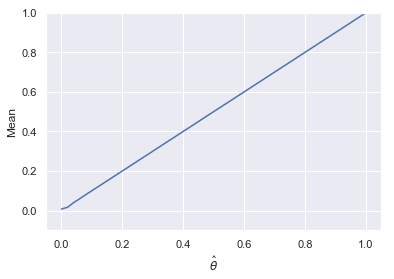

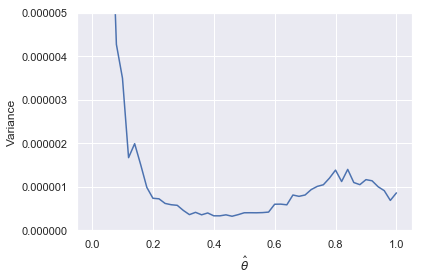

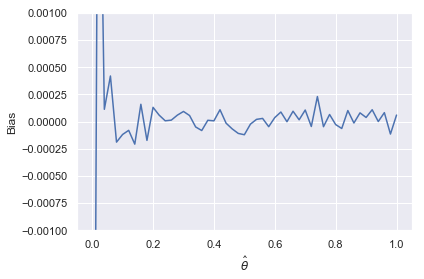

In [132]:
ys = [mus, sigmas, biases]
ylabels = ['Mean', 'Variance', 'Bias']
ylims = [(-0.1, 1), (0, 0.000005), (-0.001, 0.001)]

for y, ylabel, ylim in zip(ys, ylabels, ylims):
    plt.plot(thetas, y)
    plt.xlabel('$\hat \\theta $')
    plt.ylabel(ylabel)
    plt.ylim(ylim)
    plt.show()

# Part C